# Applied Data Science Capstone
## Jonathan Kolb

###  Capstone Project - The Battle of Neighborhoods (Week 2)
Assignment Requirements:
1. **Introduction** where you discuss the business problem and who would be interested in this project.
2. **Data** where you describe the data that will be used to solve the problem and the source of the data.
3. **Methodology** section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.
4. **Results** section where you discuss the results.
5. **Discussion** section where you discuss any observations you noted and any recommendations you can make based on the results.
6. **Conclusion** section where you conclude the report.

### Introduction/Business Problem

We have recently been hired by Kool Beanz, a coffee bean distributor who wants to open their own coffee shop in New York City. Kool Beanz is familiar with the classic economic problem of the Hot Dog Vendors: two vendors are sharing a beach, and they know that the visitors on the beach will visit the vendor that is closest, and that the vistors are evenly distributed acrosss the beach. Even if the vendors initially start out equally spaced out from each other, they can get more customers by moving closer to their rival. As a result, each vendor moves closer and closer to the middle of the beach to get more customers until they're right next to each other. This problem is used to explain the paradoxical outcome of gas stations, fast food restaurants, and coffee shops being located very close to each other - sometimes across the street! As a result, Kool Beanz has decided that the best place to open a coffee shop is as close to as many other coffee shops as possible, and has hired us to find these locations.

To translate this task into a data science problem, we've been tasked with identifying the centroid of coffee shop clusters in New York City, so that our client can then choose where to build their new coffee shop. 

### Data
We will be using the geolocation data available from Foursquare to identify the location of coffee shops in New York City. Foursquare has the coordinates of venues, as well as a venue category that describes the location (Beer Bar, Italian Restaurant, Yoga Studio, etc). While there is a specific 'Coffee Shop' category, we may want to also include other venues such as 'Cafes'. We will want to focus on just the coffee shop and similar venues with New York City itself, and not nearby locations like Yonkers.

Because coffee shops are spread out all over New York City, simply finding the closest single point to all of them is going to give us a point very close to the geographical center of city and wouldn't be very helpful. Instead, we will try to split up the coffee shops into clusters, where we'll minimize the intra-cluster distance between coffee shops and maximize the inter-cluster difference. Unlike other cluster similiarity questions we've addressed in this course, we will be looking at the literal distance.

To achieve this, we will use K-Means Clustering to identify these centroids. We will also need to compare different values of K to determine how many clusters we should create, and therefore how many candidate locations we should provide our client.

### Methodology
Because we are trying to cluster unlabeled data, we will be using the K-means model. The K-means model is an interative process where K centroids are moved to the center of their clusters and re-evaluated until a local optimum is reached. This, in theory, will be our candidate locations for our client to consider. I chose this model because it is simple, fast, and produces an intuitive result when trying to cluster unlabeled data.

Because we are dealing with the physical coordinates of venue locations, we avoid any complications with normalizing the data - we're only dealing with phsyical distance without any need to convert measurements. That leaves only two unanswered questions from the previous section:
1. Should venues similar to coffee shops, such as cafes, be included in our analysis? As is often the case in data science, this question doesn't have an objective answer and instead relies upon our best judgment.
2. What value should we for K in our model? K determines the number of clusters in our model, and is again a question of judgment. We will be using the Elbow Method to identify the point where adding additional clusters doesn't improve the model. Also, as our client's ability to consider different locations is limited and to avoid decision paralysis, we will be limiting K to a 'reasonable' number - no more than 20 candidates will be considered.

The steps taken are detailed in the notebook below, while only the conclusions will be included in the presentation.

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!pip install geopy # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip -q install folium # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [4]:
#While we could just request all venues in New York City, doing this by neighborhood is easier to cover all of NYC while excluding nearby suburbs.
# We use the data from https://geo.nyu.edu/catalog/nyu_2451_34572 that was loaded for this course.
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [5]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
neighborhoods_data = newyork_data['features']

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [8]:
#While we could identify venues around the geographical center of New York City (identified below in the next cell),
#using the neighborhoods data instead allows us to use a smaller radius when writing our query and still get good data.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [9]:
#Identifying the NYC coordinates for our maps.
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [10]:
# The code was removed by Watson Studio for sharing.

In [13]:
#A query we used in previous labs to iterate GET requests through each neighborhood.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
#Our results - all venues in all NYC neighborhoods.
newyork_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )
newyork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [15]:
# Select just coffee shop, as well as donut shop, cafe, and bagel shops
shops = ['Coffee Shop','Donut Shop','Café','Bagel Shop']
newyork_coffee = pd.DataFrame(columns=['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category'])
newyork_coffee = newyork_venues[newyork_venues['Venue Category'].isin(shops)]

In [16]:
#We're not interested in the neighborhood data beyond this point, nor the Venue names, so we drop them.
newyork_coffee = newyork_coffee.drop(columns=['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Venue'])

In [17]:
newyork_coffee.head()

,Venue Latitude,Venue Longitude,Venue Category
4,40.890459,-73.849089,Donut Shop
14,40.870280,-73.828611,Bagel Shop
30,40.885384,-73.828099,Donut Shop
73,40.885009,-73.900332,Coffee Shop
93,40.879359,-73.905077,Donut Shop


In [18]:
#Splitting up Coffee Shop from the other types of venues in our analysis.
newyork_coffee['Coffee'] = newyork_coffee['Venue Category'] == 'Coffee Shop'

In [19]:
newyork_coffee.head()

,Venue Latitude,Venue Longitude,Venue Category,Coffee
4,40.890459,-73.849089,Donut Shop,False
14,40.870280,-73.828611,Bagel Shop,False
30,40.885384,-73.828099,Donut Shop,False
73,40.885009,-73.900332,Coffee Shop,True
93,40.879359,-73.905077,Donut Shop,False


In [20]:
#We create a map of New York with the venues marked on it.
map_newyork = folium.Map(location=[40.7127281, -74.0060152], zoom_start=12)

#We'll use this color the Coffe Shops markers as blue, and the rest as red.
def color(val): 
    if val == True: 
        col = 'blue'
    else: 
        col='red'
    return col 

# add markers to map
for lat, lng, cat, group in zip(newyork_coffee['Venue Latitude'], newyork_coffee['Venue Longitude'], newyork_coffee['Venue Category'], newyork_coffee['Coffee']):
    label = '{}'.format(cat)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=color(group),
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [21]:
#We see that Coffee Shops appear to be distributed differently from the other shops. Since we're interested in Coffee Shop clusters,
#We drop the non-Coffee Shop venues.
newyork_coffee = newyork_coffee[newyork_coffee['Venue Category'] == 'Coffee Shop']

#I also clean up the dataframe a little to make it easier for me to work with.
newyork_coffee = newyork_coffee.drop(columns=['Venue Category','Coffee'])
newyork_coffee = newyork_coffee.rename(columns={"Venue Latitude": "Latitude", "Venue Longitude": "Longitude"})
newyork_coffee.head()

,Latitude,Longitude
73,40.885009,-73.900332
135,40.877531,-73.905582
140,40.873755,-73.908613
181,40.874933,-73.879404
243,40.855339,-73.855333


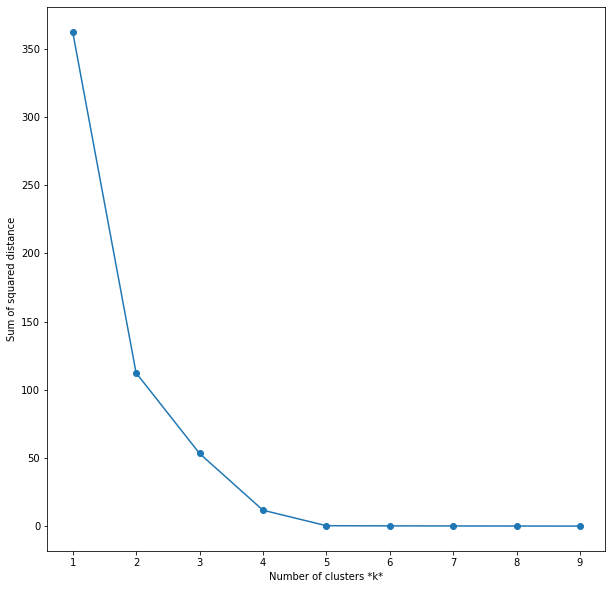

In [55]:
#We'll use the Elbow Method to identify the best number of clusters to use on this data.
#We set K to 1 through 10, calculate the sum of squared distance, and find the 'elbow' where more clusters are less helpful
import matplotlib.pyplot as plt
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(init="k-means++",n_clusters=k)
    km.fit(newyork_coffee)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(10, 10))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
#In this case, 5 clusters seems to be the limit where more clusters aren't particularly helpful.

In [48]:
#Our K-Means clustering, using 5 clusters, based on our Elbow Analysis.
k = 5

k_means = KMeans(init="k-means++", n_clusters=k, n_init=12)
k_means.fit(newyork_coffee)

KMeans(n_clusters=5, n_init=12)

In [49]:
#We create a dataframe with the cluster centers for use later on our map. These are our candidate locations.
cluster_centers = pd.DataFrame(data=k_means.cluster_centers_, columns=["Latitude", "Longitude","cluster"])
cluster_centers

,Latitude,Longitude,cluster
0,40.808012,-73.936297,2.000000e+00
1,40.729943,-73.980099,2.220446e-16
2,40.672380,-73.970650,1.000000e+00
3,40.590438,-74.143009,3.000000e+00
4,40.744270,-73.804571,1.000000e+00


In [52]:
#We add the cluster labels to our data, and then decide how to color each cluster.
def labels(val): 
    if val == 0: 
        col = 'blue'
    if val == 1:
        col = 'green'
    if val == 2:
        col = 'yellow'
    if val == 3: 
        col = 'red'
    if val == 4:
        col = 'orange'
    return col

newyork_coffee['cluster'] = k_means.labels_
newyork_coffee.head()

,Latitude,Longitude,cluster
73,40.885009,-73.900332,0
135,40.877531,-73.905582,0
140,40.873755,-73.908613,0
181,40.874933,-73.879404,0
243,40.855339,-73.855333,0


In [54]:
#We then will create a map with the venues and cluster centers on top.
map_newyork2 = folium.Map(location=[40.7127281, -74.0060152], zoom_start=12)

# add markers to map
for lat, lng, clstr in zip(newyork_coffee['Latitude'], newyork_coffee['Longitude'], newyork_coffee['cluster']):
    label = '{}'.format(clstr)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=labels(clstr),
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork2) 
#Add cluster centers    
for lat, lng, clstr in zip(cluster_centers['Latitude'], cluster_centers['Longitude'], cluster_centers['cluster']):
    label = '{}'.format(clstr)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        #popup=label,
        color='black',
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork2)  
    
    
map_newyork2

### Results/Discussion

By using K=5, we find five clusters of coffee shops in New York City that can be generally described as follows:
1. Staten Island (Red)
2. Brooklyn (Yellow)
3. Queens (Orange)
4. Lower Manhattan (Green)
5. Upper Manhattan/The Bronx (Blue)

We've also identified 5 candidates for Kool Beanz to consider as their new coffee shop location, achieving the goals laid out for us.

However, there is some space for further discussion and analysis. We can see visually that coffee shops are not evenly distributed across New York City. We can also see that there is some sort of difference between a Coffee Shop and the other categories we considered but ultimately rejected. While we can't articulate what that difference is, the geographical disparity obviously indicates that difference exists and is important to our analysis. We may want to look into this difference more deeply, in case it has some implications for our client.

Next point, we have achieved our goal and identified 5 candidates, but there are few obvious issues. First, the Staten Island and Queens clusters, while intuitively grouped together, have significant distance between the points and the centroid isn't particularly close to many of the other coffee shops. Really, only the Brooklyn and Lower Manhattan centroids seem to visually match our goal. This indicates that the K-means model isn't exactly the right tool for our purposes - we're not interested in just identifying clusters, but also interested in the density as a factor. We may want to consider different tools for this job and not just our judgment and visual inspection.

### Conclusion
In conclusion, while there is additional work that could be done, we've achieved our goals and have something ready to show our client. If this was a real world situation, we'd have to consider whether the perfect is the enemy of the good, versus there was enough time and resources available to provide the best quality analysis possible. I would certainly want to spend more time on the issue investigating density as a mathematical construct, and follow up on the Coffee Shop/Donut Shop dichotomy, but sometimes you don't have that opportunity.

Overall, I am pleased with my results and the new skills that I've learned.